<h1><center>CANDIES tutorial for E18.5 mouse brain data</center></h1>

## Read in data

In [1]:
import scanpy as sc
from os.path import join

data_dir = 'E:/yan0/ours/CANDIES/data/simulation' #please replace 'data_dir' with the download path
adata_omics1 = sc.read_h5ad(join(data_dir, 'E18_adata_rna.h5ad'))
adata_omics2 = sc.read_h5ad(join(data_dir, 'E18_adata_atac.h5ad'))

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
D:\anacon

In [3]:
def run_leiden(adata1, n_cluster, use_rep="embeddings", key_added="Nleiden", range_min=0, range_max=3, max_steps=30, tolerance=0):
    adata = adata1.copy()
    sc.pp.neighbors(adata, use_rep=use_rep)
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.leiden(adata, resolution=this_resolution)
        this_clusters = adata.obs['leiden'].nunique()

        if this_clusters > n_cluster+tolerance:
            this_max = this_resolution
        elif this_clusters < n_cluster-tolerance:
            this_min = this_resolution
        else:
            print("Succeed to find %d clusters at resolution %.3f"%(n_cluster, this_resolution))
            adata1.obs[key_added] = adata.obs["leiden"]
            
            return adata1
        
        this_step += 1
    
    print('Cannot find the number of clusters')
    adata1.obs[key_added] = adata.obs["leiden"]
    return adata1

In [4]:
import numpy as np

spatial_coords = np.array(adata_omics1.obs[['array_col', 'array_row']])
adata_omics1.obsm['spatial'] = spatial_coords

spatial_coords = np.array(adata_omics2.obs[['array_col', 'array_row']])
adata_omics2.obsm['spatial'] = spatial_coords

In [5]:
adata_omics1

AnnData object with n_obs × n_vars = 2129 × 32285
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'BlacklistRatio', 'array_col', 'array_row', 'ReadsInPeaks', 'FRIP', 'ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Combined_Clusters_annotation', 'src'
    var: 'type', 'name', 'interval'
    obsm: 'spatial'

In [6]:
adata_omics2

AnnData object with n_obs × n_vars = 2129 × 161461
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'BlacklistRatio', 'array_col', 'array_row', 'ReadsInPeaks', 'FRIP', 'ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Combined_Clusters_annotation', 'src'
    obsm: 'spatial'

In [7]:
from codes.DiTs import *
from codes.sampler import *
from codes.train_diff import *
from codes.ZINB_encoder import *
from codes.preprocess1 import *

E:\yan0\ours\CANDIES_code\tutorial
NVIDIA GeForce RTX 4060


## Data preprocessing

In [8]:
# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

# ATAC
adata_omics2 = adata_omics2[adata_omics1.obs_names].copy()  # .obsm['X_lsi'] represents the dimension reduced feature
if 'X_lsi' not in adata_omics2.obsm.keys():
    sc.pp.highly_variable_genes(adata_omics2, flavor="seurat_v3", n_top_genes=3000)
    lsi(adata_omics2, use_highly_variable=False, n_components=51)

adata_omics2.obsm['feat'] = adata_omics2.obsm['X_lsi'].copy()
adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics2.obsm['X_lsi'].shape[1])

In [9]:
from codes.get_graph import construct_neighbor_graph,adjacent_matrix_preprocessing
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

adata_omics1, adata_omics2 = construct_neighbor_graph(adata_omics1, adata_omics2)

adj = adjacent_matrix_preprocessing(adata_omics1, adata_omics2)
adj_spatial_omics1 = adj['adj_spatial_omics1'].to(device)
adj_spatial_omics2 = adj['adj_spatial_omics2'].to(device)

In [12]:
ae_model = encoder_ZINB(
    adata=adata_omics1,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    epochs=300,
    dim_output=64
)

adata_omics1.obsm['emb_ZINB'], adj_mat = ae_model.train()

 18%|█▊        | 55/300 [00:00<00:01, 164.51it/s]

Early stop!
Optimization finished


In [11]:
seed = 2024
seed_everything(seed)

from codes.AutoEncoder import train_atac
# from GAT import train_model
train_atac(adata_omics2, adj_spatial_omics2, epochs=600)

Epoch [100/600], Loss atac: 0.3719
Epoch [200/600], Loss atac: 0.2707
Epoch [300/600], Loss atac: 0.2583
Epoch [400/600], Loss atac: 0.2507
Epoch [500/600], Loss atac: 0.2471
Epoch [600/600], Loss atac: 0.2430
Training complete!
Latent representations have been successfully added to adata_omics.obsm!


In [13]:
adata_omics1 = run_leiden(adata_omics1, n_cluster=14, use_rep="emb_ZINB", key_added="AE")
adata_omics2 = run_leiden(adata_omics2, n_cluster=14, use_rep="emb_latent_omics2", key_added="AE")

Succeed to find 14 clusters at resolution 1.312
Succeed to find 14 clusters at resolution 0.938


## Modality selcetion
The modality selcetion of CANDIES requires following input data: 
<br>
1. With annotation: cluster results of the two modality after encoding phase, and the annotation labels.
<br>
2. Without annotation: cluster results and the embeddings of the two modality after encoding phase.
<br>


In [14]:
from codes.modality_selection import modality_selection
modality_selection(adata_omics1.obs['AE'],adata_omics2.obs['AE'],ground_truth=adata_omics1.obs['Combined_Clusters'])

We recommend you use modality 2 as condition in the denoise phase!


## Denoise phase
Before the diffusion process, we need to align the two modality embeddings according to the spatial coordinates.

In [16]:
slices_omics1_spatial = adata_omics1.obsm['spatial']
slices_omics2_spatial = adata_omics2.obsm['spatial']

emb_latent_omics1 = adata_omics1.obsm['emb_ZINB']
emb_latent_omics2 = adata_omics2.obsm['emb_latent_omics2']

import pandas as pd

df_omics1 = pd.DataFrame(emb_latent_omics1, index=[tuple(coord) for coord in slices_omics1_spatial])
df_omics2 = pd.DataFrame(emb_latent_omics2, index=[tuple(coord) for coord in slices_omics2_spatial])

df_omics2_aligned = df_omics2.reindex(df_omics1.index)

aligned_emb_latent_omics1 = df_omics1.to_numpy()
aligned_emb_latent_omics2 = df_omics2_aligned.to_numpy()

print(aligned_emb_latent_omics1.shape)
print(aligned_emb_latent_omics2.shape)

(2129, 64)
(2129, 64)


In [17]:
aligned_emb_latent_omics1.std()

2.837152

In [18]:
aligned_emb_latent_omics2.std()

1.2348396

In [19]:
class ConditionalDiffusionDataset():
    def __init__(self, adata_omics1, adata_omics2):
        self.adata_omics1 = adata_omics1
        self.adata_omics2 = adata_omics2

        self.st_sample = torch.tensor(self.adata_omics1, dtype=torch.float32)
        self.con_sample = torch.tensor(self.adata_omics2, dtype=torch.float32)
        self.con_data = torch.tensor(self.adata_omics2, dtype=torch.float32)

    def __len__(self):
        return len(self.adata_omics1)

    def __getitem__(self, idx):
        return self.st_sample[idx], self.con_sample[idx], self.con_data

In [20]:
dataset = ConditionalDiffusionDataset(aligned_emb_latent_omics1, aligned_emb_latent_omics2) # denoise the first modality, condition on the second modality.

seed = 2024
seed_everything(seed)

com_mtx = run_diff(
    dataset,

    k=3,
    batch_size=512,
    hidden_size=256,
    learning_rate=1e-3,

    num_epoch=1000,
    diffusion_step=800,

    depth=6,
    head=16,
    pca_dim=50,

    device='cuda:0',
    classes=6,
    patience=40,

    bias=0.5
)

*******************  Fold 1  (total 3 folds)  ********************


 37%|█████████▏               | 368/1000 [01:55<03:18,  3.18it/s, noise loss:0.0676855, lr:1.00e-06]


Early stop(patience:40)!!


time: 0: 100%|██████████| 800/800 [01:36<00:00,  8.28it/s]  


*******************  Fold 2  (total 3 folds)  ********************


 35%|████████▊                | 351/1000 [01:51<03:25,  3.16it/s, noise loss:0.0738376, lr:1.00e-06]


Early stop(patience:40)!!


time: 0: 100%|██████████| 800/800 [01:36<00:00,  8.32it/s]  


*******************  Fold 3  (total 3 folds)  ********************


 45%|███████████▏             | 446/1000 [02:19<02:53,  3.19it/s, noise loss:0.0754287, lr:1.00e-07]


Early stop(patience:40)!!


time: 0: 100%|██████████| 800/800 [01:36<00:00,  8.33it/s]  


In [21]:
adata_omics1.obsm['denoise_emb'] = com_mtx

In [26]:
tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata_omics1, key='denoise_emb', add_key='Denoise', n_clusters=14, end=2, method=tool, use_pca=True)

fitting ...
  |======================================================================| 100%


## Integration phase

In [28]:
from codes.integration import *

In [29]:
adata1 = adata_omics1.copy()
adata2 = adata_omics2.copy()

In [30]:
data_type = '10x'
adata1.obsm['feat'] = adata1.obsm['denoise_emb']
adata2.obsm['feat'] = adata2.obsm['emb_latent_omics2']

adata1, adata2 = construct_neighbor_graph(adata1, adata2)

In [31]:
adj = adjacent_matrix_preprocessing(adata1, adata2)
adj_spatial_omics1 = adj['adj_spatial_omics1'].to(device)
adj_spatial_omics2 = adj['adj_spatial_omics2'].to(device)
adj_feature_omics1 = adj['adj_feature_omics1'].to(device)
adj_feature_omics2 = adj['adj_feature_omics2'].to(device)

In [32]:
features_omics1 = torch.FloatTensor(adata1.obsm['feat'].copy()).to(device)
features_omics2 = torch.FloatTensor(adata2.obsm['feat'].copy()).to(device)

seed = 2025
seed_everything(seed)

result = train_and_infer(
    features_omics1=features_omics1,
    features_omics2=features_omics2,
    adj_spatial_omics1=adj_spatial_omics1,
    adj_feature_omics1=adj_feature_omics1,
    adj_spatial_omics2=adj_spatial_omics2,
    adj_feature_omics2=adj_feature_omics2,
    device=device,
    epochs=100
)

Training Progress: 100%|██████████| 100/100 [00:32<00:00,  3.11it/s, Total Loss=15.6, Contrastive Loss (Spatial)=6.15, Contrastive Loss (Feature)=6.96, Reconstruction Loss 1=0.448, Reconstruction Loss 2=0.84, Reconstruction Loss 3=0.415, Reconstruction Loss 4=0.817]


In [33]:
adata = adata1.copy()
adata.obsm['CANDIES'] = result['emb_latent_combined'].detach().cpu().numpy().copy()

## Visualization

In [35]:
clustering(adata, key='CANDIES', add_key='CANDIES', n_clusters=14, end=1, method=tool, use_pca=True)

fitting ...
  |======================================================================| 100%


In [37]:
sc.pp.neighbors(adata, use_rep='CANDIES', n_neighbors=10)
sc.tl.umap(adata)

In [38]:
from sklearn.metrics import adjusted_rand_score

# 提取 ground_truth 和 AE 列
ground_truth = adata.obs['Combined_Clusters']
ae = adata.obs['CANDIES']

# 计算 ARI
ari_score_ours = adjusted_rand_score(ground_truth, ae)

print(f"Adjusted Rand Index (ARI) between ground_truth and AE: {ari_score_ours:.4f}")

Adjusted Rand Index (ARI) between ground_truth and AE: 0.6368


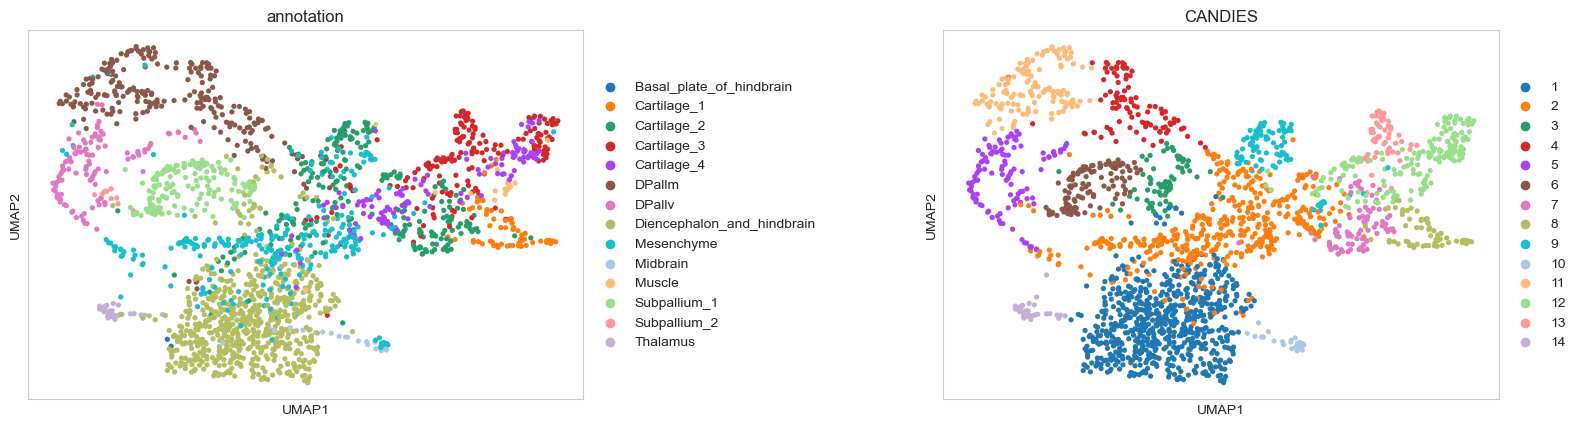

In [40]:
sc.pl.umap(adata, color=["Combined_Clusters_annotation", "CANDIES"], title=["annotation", "CANDIES"],wspace=0.5)

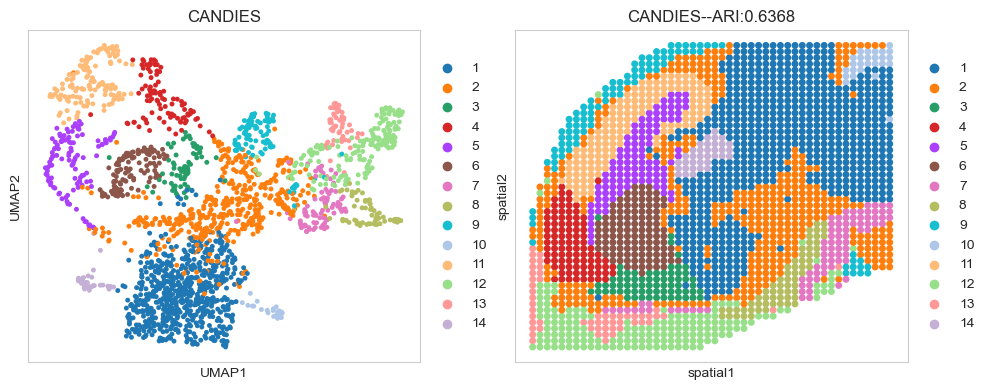

In [41]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(10, 4))

sc.pl.umap(adata, color='CANDIES', ax=ax_list[0], title='CANDIES', s=50, show=False)
sc.pl.embedding(adata, basis='spatial', color='CANDIES', ax=ax_list[1],
                title=f'CANDIES--ARI:{ari_score_ours:.4f}', s=100, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()